In [ ]:
import tensorflow_addons as tfa
import tensorflow as tf
import sys
import seaborn as sns
import os.path
import os
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.metrics import Recall, Precision
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score
from pathlib import Path
from multiprocessing import Process,Value
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from IPython.display import clear_output
from imgaug import augmenters as iaa
from google.colab import drive
from contextlib import redirect_stdout

drive.mount("/content/gdrive", force_remount=True)

drive_path = "/content/gdrive/MyDrive/Project-KLM" 
os.chdir(drive_path)

Mounted at /content/gdrive


# Introduction to our Work

Our approach towards solving the segmentation problem was to employ a U-Net, originally introduced <a href="https://arxiv.org/pdf/1505.04597.pdf)%e5%92%8c%5bTiramisu%5d(https://arxiv.org/abs/1611.09326.pdf">here</a>, a frequently used model for segmentation problems, that we adapt to this particular problem.

In order to solve the issue of predicting on nearly arbitrary sizes of images, since the U-Net usually is trained upon a fixed input size, and therefore also is restricted to inferring same input sizes, instead of simply resizing images and losing information, we use a sliding window technique. Particularly, we train our model on some size (has to be a power of 2 given the implemented structure, for example 256x256). And then, to predict an image which is, say 400x400, we divide this image into patches of 256x256 (which can be accomplished with various strides), predict for all of those patches, and combine the results in a single prediction.

In this notebook, we have combined multiple results regarding :
- Selecting Data Augmentation
- Selecting the Level (number of downwards and upwards convolutions) of our U-Net
- Different Types of Sliding Window Approaches
- Sliding Window Stride Selection
- Post-Processing methods to use

# Loading the Data

In this part, we load all the training images without data augmentation, in a training and validation set. Throughout all this notebook, we will always use the training set to train our network and the validation set to validate each feature (Data Augmentation, Level of our U-Net, Post-Processing)


In [ ]:
from libs.models import *
from libs.ImageGen import *
from libs.sliding_window import *
from libs.post_process import *
from libs.threshold import *
from libs.averaging import *
from libs.submission import *
from libs.augmentation import *

In [ ]:
#Parameters to load the data
input_dir = "training/images"
target_dir = "training/groundtruth/"
img_size = (400, 400) #Don't edit size
batch_size = 100
seed = 10

#Don't apply any data augmentation here, we just load the pictures in RAM
grayscale_x = False
crop_length = None 
aug_gen_args = {'validation_split' : 0.2}  #Only param is validation 80/20 split

#Load the data (80 training images, 20 validation images)
imgen = ImageGenerator(input_dir, target_dir, aug_gen_args, seed, img_size, batch_size, grayscale_x, force_batch_size=False)
train_gen, valid_gen = imgen.get_normal_generator()
train_x, train_y = next(train_gen)
valid_x, valid_y = next(valid_gen)

Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


# Augmenting validation set

We augment our validation set by adding full rotations (multiple of 90 degrees), and flipping images of our previous validation set. This simply forces our models to be slightly more robust.

In [ ]:
# set seed for reprodubility and retrieve (new) data to serve as validation
np.random.seed(seed)
new_x, new_y = apply_augments(valid_x), apply_augments(valid_y)

# validation set on pred_n = 96 images out of the 240 which result from the flips and rotations
pred_n = 96
selected_indices = np.random.randint(0,len(new_x),pred_n)
new_x, new_y = new_x[selected_indices], new_y[selected_indices]

cropper = iaa.Sequential([iaa.size.CropToFixedSize(width=256,height=256,random_state=1)])
cropped_x = cropper.augment_images(new_x)

cropper = iaa.Sequential([iaa.size.CropToFixedSize(width=256,height=256,random_state=1)])
cropped_y = cropper.augment_images(new_y)

# create batches from selected validation set
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

batched_x = [np.stack(x) for x in chunks(cropped_x,16)]
batched_y = [np.stack(y) for y in chunks(cropped_y,16)]

valid_cropped = (batched_x,batched_y)

print("Validation batches are of shape:")
batched_x[0].shape, batched_y[0].shape

Validation batches are of shape:


((16, 256, 256, 3), (16, 256, 256, 1))

In [ ]:
aug_gen_args = {
    'rotation_range' : 90,
    'width_shift_range' : 0.2,
    'height_shift_range' : 0.2,
    'horizontal_flip' : False,
    'vertical_flip' : False,
}

Since big models tend to be of a high size (6Go for a level 7 U-net), we couldn't save all models in our limited (15Go) drive size. Thus, instead of saving all models in our experiments, in order to provide results that can be verified, we saved our predictions on validation sets for the models we tried.

In [ ]:
VALID_PREDICTIONS = "./validation_predictions/"

# Selecting Data Augmentation Parameters

<img src=https://miro.medium.com/max/2026/1*rvwzKkvhlDN3Wo_4Oay_4Q.png height="100">

Initially, we wanted to select Data Augmentation parameters by doing a RandomSearch / GridSearch, to validate the empirical results we had obtained before when testing different augmentations, unfortunately, it is hard to make multiple searches work with Keras (GPU Out of Memory crashes for example), even with the Keras wrapper from Sklearn. Another issue is that, to be useful, the search has to be fairly extensive (search for augments, at the same time as U-Net level, learning rate, dropout rate), while training enough so that each model reaches its peak efficiency, which makes it infeasible in the timeframe. 

From literature in U-nets, we know that rotation augmentation is generally useful (see the <a href="https://arxiv.org/pdf/1505.04597.pdf)%e5%92%8c%5bTiramisu%5d(https://arxiv.org/abs/1611.09326.pdf">original</a> Unet paper, section 3.1, but also image tasks in general), and we know in this particular case, that road geometry doesn't lose context when rotated, so it is useful to use rotations augments.

In the end, we thus settled for these augments :

 aug_gen_args = {
   - 'rotation_range' : 90,
   -  'width_shift_range' : 0.2,
   -  'height_shift_range' : 0.2,
   -  'horizontal_flip' : False,
   -  'vertical_flip' : False

}

We could argue that using horizontal and vertical flips would lead to more related data, and thus add "free" training samples, but our empirical results lead to us not using them. 

With more time we would have liked to provide a more in depth search, but unfortunately we had to settle for this.

# Selecting number of levels of our U-Net
<img src=https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png height="200">

U-Nets are modular architectures, where a wide array of parameters can vary. One parameter which makes an important difference (other than the obvious hyperparameters such as learning rate, dropout), is the number of levels of downsampling and upsampling. 

From literature, we know that in general, the more levels, the better, but that higher levels tend to not fit in memory. Using colab, at most a level 7 U-Net was trainable, and in this part, we compare the performance we obtain using level 5 to 7 U-Nets.

Comparing these models are done based on the validation f1-score we obtain, using two prediction techniques : Sliding windows with and without rotations (rotations of 0,90,180,270 degrees) - Remember that our objective is to predict images of any size, therefore we incorporate this directly into our validation technique. 

Since we are training different models from scratch, they may lead to completely different decision boundaries (the threshold from non road to road is not always set at 0.5), due to differing complexity captured by the models, so long as they could differentiate the distribution at some threshold, we were satisfied. Thus, we split our validation images once again, the first half is used to select the threshold at which we consider a pixel to be a road, and the second is used for computing the actual f1-score.

We acknowledge that in this split, the sets for which we select our threshold and the validation images are correlated, as they only differ due to data augmentation, however, we argue that since we are not interested in determining the best threshold, but rather, to compare models, regardless of the threshold selected, it doesn't matter, as we just select the best performing f1-score for each different configuration.

In [ ]:
def create_crop_datagen(x, y, aug_gen_args, crop_size, seed):
  """Generates a crop generator given the augment arguments, crop size and seed"""
  datagen = ImageDataGenerator(**aug_gen_args)
  x_gen   = datagen.flow(x, seed=seed,batch_size=16)
  y_gen   = datagen.flow(y, seed=seed,batch_size=16)
  gen = zip(x_gen, y_gen)
  return crop_generator(gen, crop_size, seed)
  
def create_validation_predictions(model, valid_x):
  """Creates predictions using normal and rotated prediction"""
  normal_predictions = [np.asarray(predict_from_image(model, valid_x[i], stride=72)) for i in tqdm(range(valid_x.shape[0]),desc='Predicting unpadded postprocessing')]
  rotated_predictions = [np.asarray(predict_from_image_rotated(model, valid_x[i], stride=72, rotations=[0,90,180,270], pad=False)) for i in tqdm(range(valid_x.shape[0]),desc='Predicting rotated unpadded postprocessing')]
  return normal_predictions, rotated_predictions

def save_predictions_to_path(out_dir, normal_preds, rotated_preds):
  """Saves normal and rotated predictions to the given path"""
  normal_dir, rotated_dir = [os.path.join(out_dir, subdir) for subdir in ["normal/","rotated/"]]
  for i in tqdm(range(new_x.shape[0]),desc='Saving images'):
    name = "{:03d}.png".format(i)
    cv2.imwrite(os.path.join(normal_dir, name), normal_preds[i])
    cv2.imwrite(os.path.join(rotated_dir, name), rotated_preds[i])

In [ ]:
#@title Create folders in which to save predictions
model_param_path = VALID_PREDICTIONS + "level_selection/"
LEVELS = [5,6,7]
for i in LEVELS:
  folder_name = f"level_{i}/"
  Path(model_param_path + folder_name + "normal/").mkdir(parents=True, exist_ok=True)
  Path(model_param_path + folder_name + "rotated/").mkdir(parents=True, exist_ok=True)

In [ ]:
#@title Run for all levels (& saving output predictions as images in order to run in parallel)
def evaluate_model_level(level,output_dir,stdout) :
  sys.stdout = stdout
  #Create data generator using previous augments
  datagen = train_gen = create_crop_datagen(train_x, train_y, aug_gen_args, 256, seed)
  
  #Create and fit model of given level
  print('Creating model of level ' + str(level))
  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3,patience=5, restore_best_weights=True)]
  model = unet(post_processing=False, levels=level, metrics=[Recall(), Precision()])
  model.fit(train_gen, epochs=20, validation_data=valid_cropped, steps_per_epoch=250,callbacks = callbacks)
  print('Predicting ...')

  #Create predictions with and without rotations on sliding window
  normal_predictions, rotated_predictions = create_validation_predictions(model, new_x)
  
  #Save predictions as images
  save_predictions_to_path(output_dir, normal_predictions, rotated_predictions)

# Only try for up to level 7 U-Net, otherwise don't have enough resources
# Commented out so you don't accidentally run it

# #For each level, train a model and predict
# for level in LEVELS:
#   folder_name = f"level_{level}/"
#   p = Process(target=evaluate_model_level, args=(level,model_param_path + folder_name,sys.stdout))
#   p.start()
#   p.join()
#   K.clear_session()


Creating model of level 7
Epoch 1/20
250/250 [==============================] - 535s 2s/step - loss: 0.7072 - recall: 0.6606 - precision: 0.4067 - val_loss: 0.6736 - val_recall: 0.5612 - val_precision: 0.6459
Epoch 2/20
250/250 [==============================] - 536s 2s/step - loss: 0.6181 - recall: 0.6227 - precision: 0.8737 - val_loss: 0.6285 - val_recall: 0.5717 - val_precision: 0.8538
Epoch 3/20
250/250 [==============================] - 538s 2s/step - loss: 0.5992 - recall: 0.6972 - precision: 0.8966 - val_loss: 0.6209 - val_recall: 0.6605 - val_precision: 0.8466
Epoch 4/20
250/250 [==============================] - 536s 2s/step - loss: 0.5784 - recall: 0.7593 - precision: 0.9193 - val_loss: 0.6213 - val_recall: 0.4947 - val_precision: 0.8714
Epoch 5/20
250/250 [==============================] - 536s 2s/step - loss: 0.5632 - recall: 0.7917 - precision: 0.9315 - val_loss: 0.5945 - val_recall: 0.7353 - val_precision: 0.8463
Epoch 6/20
250/250 [==============================] - 537s 


{7: 0.0}
{7: 0.0}


In [ ]:
#@title Visualizing the performance comparison of all levels
#Try different values of threshold, as it is dependent on the model
THRESHOLDS = [(x,create_vanilla_threshold(x)) for x in np.linspace(0.1*255,0.7*255,num=20)]
NUM_TRAIN   = 20

# prediction scoring  
PATH = VALID_PREDICTIONS + "level_selection/"
typing = ['normal', 'rotated']
levels = list(filter(lambda x : not x.startswith("."),os.listdir(PATH)))
scores_multiple = np.empty((len(levels), len(typing)))
for i,comb in enumerate(levels):
  for j,typ in enumerate(typing):
    #Read all images
    imgs = [os.path.join(PATH,comb,typ, x) for x in sorted(os.listdir(PATH + comb + "/" + typ))]
    read_imgs = [np.mean(cv2.imread(img),axis=2) for img in tqdm(imgs,desc='Reading images',leave=False)]

    #Use a few images to determine the best threshold
    train_imgs = read_imgs[:NUM_TRAIN]
    valid_imgs = read_imgs[NUM_TRAIN:]
    train_target    = new_y[:NUM_TRAIN]
    valid_target    = new_y[NUM_TRAIN:]

    #Find best threshold on test images
    best_func, best_thresh, best_score = select_best_threshold(THRESHOLDS, train_imgs, train_target.astype(int))

    #Use selected threshold on the rest of validation images
    score = compute_score_thresholded(best_func, valid_imgs, valid_target)

    scores_multiple[i,j] = score
    print("{}, {} {:.3f}, gotten with selected threshold of {:03.0f}".format(comb,typ,score,best_thresh))
  

level_5, normal 0.857, gotten with selected threshold of 098


level_5, rotated 0.875, gotten with selected threshold of 098


level_6, normal 0.870, gotten with selected threshold of 114


level_6, rotated 0.880, gotten with selected threshold of 138


level_7, normal 0.871, gotten with selected threshold of 122


level_7, rotated 0.878, gotten with selected threshold of 138


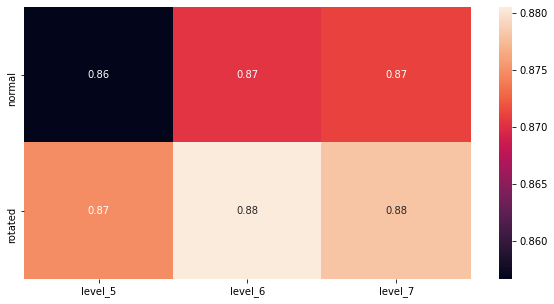

In [ ]:
#@title Heatmap result
plt.figure(figsize=(10,5))
sns.heatmap(scores_multiple.T, xticklabels=levels, yticklabels=typing, annot=True)

We are very happy with this result, as it shows that higher levels of U-Nets do tend to a better validation accuracy. We also see that it is very important to select the right threshold, as it seems that higher levels prefer a threshold at around 0.5 (0.5*255 = 127), while the level 5 network worked better with lower thresholds. Since the results are so close together between level 6 and level 7, and the fact that higher level models may need more training, we select level 7s.

# Effect of Sliding Window (and trained model) size

In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1MB 10.5MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [ ]:
#@title Comparing window size's role in model performance
np.random.seed(seed)
tf.random.set_seed(seed)

tqdm_callback = tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False, leave_overall_progress=False)

THRESHOLDS = [(x,create_vanilla_threshold(x)) for x in np.linspace(0.1*255,0.7*255,num=20)]

WINDOW_SIZE = [64,128,256]

LEVELS = 7
scores = {}
def evaluate_model_window(window,f1_score_window,stdout) :
  sys.stdout = stdout
  #Create data generator from previous augments
  train_gen = create_crop_datagen(train_x, train_y, aug_gen_args, window, seed)

  #Only 16 validation images during training, just as an indicator
  crop_valid_gen = ((a[:16],b[:16]) for (a,b) in crop_generator(valid_gen, window, seed))
  crop_valid = next(crop_valid_gen)

  #Train a Unet with the chosen window size
  model = unet(post_processing=False,input_size=(window,window,3), levels=LEVELS,metrics=[Recall(), Precision()])
  model.fit(train_gen, epochs=5, validation_data=crop_valid, steps_per_epoch=200)
  print('Predicting ...')

  #Find best threshold on training data
  train_predictions = [np.asarray(predict_from_image(model, train_x[i], window_size=window, stride=32)) for i in range(train_x.shape[0])]
  best_func, best_thresh, best_score = select_best_threshold(THRESHOLDS, train_predictions, train_y)
  print("Best threshold : ", best_thresh)

  #Predict validation images, threshold them
  predictions = [np.asarray(predict_from_image(model, valid_x[i], window_size=window, stride=32)) for i in range(valid_x.shape[0])]

  #Get F1-score
  f1 = compute_score_thresholded(best_func, predictions, valid_y)
  f1_score_window.value = f1

# Commented so you don't run it accidentally

# for window in WINDOW_SIZE:
#   #Either load model, or fit it if we don't have it
#     print(f"Training for window size : {window}")
#     score = Value('d', 0.0)
#     p = Process(target=evaluate_model_window, args=(window, score, sys.stdout))
#     p.start()
#     p.join()
#     scores[window] = score.value
#     K.clear_session()

  #Compute for each model the f1_score on validation

Training for window size : 64
Epoch 1/5
200/200 [==============================] - 152s 759ms/step - loss: 0.4199 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.4423 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/5
200/200 [==============================] - 151s 757ms/step - loss: 0.3422 - recall: 0.3614 - precision: 0.6199 - val_loss: 0.3685 - val_recall: 0.5729 - val_precision: 0.7930
Epoch 3/5
200/200 [==============================] - 152s 759ms/step - loss: 0.3260 - recall: 0.6181 - precision: 0.6369 - val_loss: 0.3100 - val_recall: 0.6483 - val_precision: 0.8291
Epoch 4/5
200/200 [==============================] - 152s 758ms/step - loss: 0.3105 - recall: 0.6541 - precision: 0.6822 - val_loss: 0.3292 - val_recall: 0.7783 - val_precision: 0.8537
Epoch 5/5
200/200 [==============================] - 152s 759ms/step - loss: 0.3024 - recall: 0.6809 - precision: 0.6834 - val_loss: 0.3666 - val_recall: 0.6627 - val_precision: 0.8820
Predicting ...
Best threshold

In [ ]:
scores

{64: 0.6515652748661387, 128: 0.7773868530733126, 256: 0.7943411849624166}

We conclude that a larger window size increases the model performance. This can be explained from the fact that a smaller window is provided with less context which is essential in the performance of U-Nets, which are able to capture local context through their architecture. We acknowledge that this is not a lot of epochs, but we quickly determine a trend.

# Weighted Loss

In the previous experiments we noticed that the validation recall was often less than the validation precision. In this part we try to balance the class weights by using a weighted loss.

In [ ]:
#@title Creation of output folders to save images for later analysis
validation_prediction_path = VALID_PREDICTIONS + "weighted_losses/"
WEIGHTS = [0.4,0.45,0.55,0.6]
for w in WEIGHTS:
  folder_name = f"weigth_{w}/"
  Path(validation_prediction_path + folder_name + "normal/").mkdir(parents=True, exist_ok=True)
  Path(validation_prediction_path + folder_name + "rotated/").mkdir(parents=True, exist_ok=True)

In [ ]:
#@title Definition of closure for Weighted Binary Cross Entropy
def create_weighted_binary_cross_entropy(zero_weight, one_weight):
  def weighted_binary_crossentropy(y_true, y_pred):
          # Calculate the binary crossentropy
          b_ce = K.binary_crossentropy(y_true, y_pred)

          # Apply the weights
          weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
          weighted_b_ce = weight_vector * b_ce

          # Return the mean error
          return K.mean(weighted_b_ce)

  return weighted_binary_crossentropy

In [ ]:
#@title Train model with differing class weights and save predictions
def evaluate_model_weigthed_loss(weigth,output_dir,stdout) :
  sys.stdout = stdout
  train_gen = create_crop_datagen(train_x, train_y, aug_gen_args, 256, seed)
  
  print('Loading model with weigths ' + str(weigth))
  loss = create_weighted_binary_cross_entropy(1.0 - weigth,weigth)

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3,patience=10, restore_best_weights=True)]

  #Create model
  model = unet(post_processing=False,loss=loss, levels=7,metrics=[Recall(), Precision()])
  model.fit(train_gen,epochs=10, validation_data=valid_cropped, steps_per_epoch=350,callbacks = callbacks)

  #Create validation predictions
  print('Predicting ...')
  normal_predictions, rotated_predictions = create_validation_predictions(model, new_x)

  #Save all prediction images
  save_predictions_to_path(output_dir, normal_predictions, rotated_predictions)

#For each weight, train a model and predict
for w in WEIGHTS:
  folder_name = f"weigth_{w}/"
  p = Process(target=evaluate_model_weigthed_loss, args=(w,validation_prediction_path + folder_name,sys.stdout))
  p.start()
  p.join()
  K.clear_session()

# print(scores)

In [ ]:
#@title Visualizing the performance comparison of different weigths
#Try different values of threshold, as it is dependent on the model
THRESHOLDS = [(x,create_vanilla_threshold(x)) for x in np.linspace(0.1*255,0.7*255,num=20)]
NUM_TRAIN   = 20

# prediction scoring  

typing = ['normal', 'rotated']
weights = list(filter(lambda x : not x.startswith("."),os.listdir(validation_prediction_path)))
scores_multiple = np.empty((len(weights), len(typing)))
for i,w in enumerate(weights):
  for j,typ in enumerate(typing):
    #Read all images
    imgs = [os.path.join(validation_prediction_path,w,typ, x) for x in sorted(os.listdir(validation_prediction_path + w + "/" + typ))]
    read_imgs = [np.mean(cv2.imread(img),axis=2) for img in tqdm(imgs,desc='Reading images',leave=False)]

    #Use a few images to determine the best threshold
    train_imgs = read_imgs[:NUM_TRAIN]
    valid_imgs = read_imgs[NUM_TRAIN:]
    train_target    = new_y[:NUM_TRAIN]
    valid_target    = new_y[NUM_TRAIN:]

    #Find best threshold on test images
    best_func, best_thresh, best_score = select_best_threshold(THRESHOLDS, train_imgs, train_target.astype(int))

    #Use selected threshold on the rest of validation images
    score = compute_score_thresholded(best_func, valid_imgs, valid_target)

    scores_multiple[i,j] = score
    print("{}, {} {:.3f}, gotten with selected threshold of {:03.0f}".format(w,typ,score,best_thresh))
  

weigth_0.4, normal 0.827, gotten with selected threshold of 090


weigth_0.4, rotated 0.867, gotten with selected threshold of 090


weigth_0.45, normal 0.855, gotten with selected threshold of 122


weigth_0.45, rotated 0.873, gotten with selected threshold of 138


weigth_0.55, normal 0.844, gotten with selected threshold of 122


weigth_0.55, rotated 0.868, gotten with selected threshold of 098


weigth_0.6, normal 0.837, gotten with selected threshold of 130


weigth_0.6, rotated 0.858, gotten with selected threshold of 114


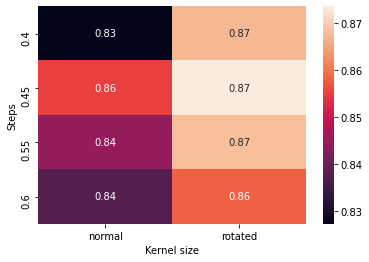

In [ ]:
sns.heatmap(scores_multiple, xticklabels=typing, yticklabels=WEIGHTS,annot=True)
plt.xlabel('Kernel size')
plt.ylabel('Weigths')
plt.show()

Interestingly, we find that the 0.45 weighting worked the best, which is maybe unintuitive, since we thought that giving more weights to the roads would lead to a higher recall, and in turn a higher f1. It seems like it is however not the case here. Since the f1-scores obtained are actually lower than our other f1-scores obtained earlier, we did not delve further into this custom loss.

# Averaging out Models

In [ ]:
#@title Create folders in which to save predictions
validation_prediction_path = VALID_PREDICTIONS + "averaging_models/"
LEVEL = 5
##Depends on the number of trained level 5 models that are saved.
## ! There are only 10 saved !
NUMBER_OF_MODELS = 10
for i in range(NUMBER_OF_MODELS):
  folder_name = f"model_{LEVEL}_{i}/"
  Path(validation_prediction_path + folder_name + "normal/").mkdir(parents=True, exist_ok=True)
  Path(validation_prediction_path + folder_name + "rotated/").mkdir(parents=True, exist_ok=True)

In [ ]:
#@title Train multiple Level 5 models (save output predictions as images in order to run in parallel)
def evaluate_models(i,output_dir,stdout) :
  sys.stdout = stdout
  seed = random.randint(0,2**32 -1 )
  train_gen = create_crop_datagen(train_x, train_y, aug_gen_args, 256, seed)
  
  print(f'Loading model {i}')
  callbacks = []
  callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3,patience=5, restore_best_weights=True))

  ##We directly load already trained models
  #This line has to be commented to train new models
  model = keras.models.load_model(f'./models/Level5/model_{i}' )

  ##Uncomment the next two lines if you want to train your own level 5 models
  #model = unet(post_processing=False, levels=LEVEL,metrics=[Recall(), Precision()])
  #model.fit(train_gen, epochs=10, validation_data=valid_cropped, steps_per_epoch=250,callbacks = callbacks)

  #Create validation predictions
  print('Predicting ...')
  normal_predictions, rotated_predictions = create_validation_predictions(model, new_x)

  #Save all prediction images
  save_predictions_to_path(output_dir, normal_predictions, rotated_predictions)

#for i in range(NUMBER_OF_MODELS):
#  folder_name = f"model_{LEVEL}_{i}/"
#  p = Process(target=evaluate_models, args=(i,validation_prediction_path + folder_name,sys.stdout))
#  p.start()
#  p.join()
#  K.clear_session()


Loading model 0
Predicting ...



Loading model 1
Predicting ...



Loading model 2
Predicting ...



Loading model 3
Predicting ...



Loading model 4
Predicting ...



Loading model 5
Predicting ...



Loading model 6
Predicting ...



Loading model 7
Predicting ...



Loading model 8
Predicting ...



Loading model 9
Predicting ...


In [ ]:
#@title Result of all models
#Try different values of threshold, as it is dependent on the model
THRESHOLDS = [(x,create_vanilla_threshold(x)) for x in np.linspace(0.1*255,0.7*255,num=20)]
NUM_TRAIN   = 20

# prediction scoring  
typing = ['normal', 'rotated']

models = list(filter(lambda x : not x.startswith(".") and x.startswith(f'model_{LEVEL}'),os.listdir(validation_prediction_path)))
print(models)
all_predictions = []
all_f1_scores = []

scores_multiple = np.empty((len(models), len(typing)))
for i,comb in enumerate(models):
  for j,typ in enumerate(typing):
    #Read all images
    imgs = [os.path.join(validation_prediction_path,comb,typ, x) for x in sorted(os.listdir(validation_prediction_path + comb + "/" + typ))]
   
    read_imgs = [np.mean(cv2.imread(img),axis=2) for img in tqdm(imgs,desc='Reading images',leave=False)]

    all_predictions.append(read_imgs)
    #Use a few images to determine the best threshold
    train_imgs = read_imgs[:NUM_TRAIN]
    valid_imgs = read_imgs[NUM_TRAIN:]
    train_target    = new_y[:NUM_TRAIN]
    valid_target    = new_y[NUM_TRAIN:]

    #Find best threshold on test images
    best_func, best_thresh, best_score = select_best_threshold(THRESHOLDS, train_imgs, train_target.astype(int))

    #Use selected threshold on the rest of validation images
    score = compute_score_thresholded(best_func, valid_imgs, valid_target)
    all_f1_scores.append(score)
    scores_multiple[i,j] = score
    print("{}, {} {:.3f}, obtained with selected threshold of {:03.0f}".format(comb,typ,score,best_thresh))




['model_5_0', 'model_5_1', 'model_5_2', 'model_5_3', 'model_5_4', 'model_5_5', 'model_5_6', 'model_5_7', 'model_5_8', 'model_5_9']


model_5_0, normal 0.852, obtained with selected threshold of 122


model_5_0, rotated 0.874, obtained with selected threshold of 106


model_5_1, normal 0.870, obtained with selected threshold of 098


model_5_1, rotated 0.883, obtained with selected threshold of 098


model_5_2, normal 0.860, obtained with selected threshold of 122


model_5_2, rotated 0.879, obtained with selected threshold of 114


model_5_3, normal 0.865, obtained with selected threshold of 130


model_5_3, rotated 0.880, obtained with selected threshold of 114


model_5_4, normal 0.862, obtained with selected threshold of 146


model_5_4, rotated 0.882, obtained with selected threshold of 146


model_5_5, normal 0.864, obtained with selected threshold of 122


model_5_5, rotated 0.879, obtained with selected threshold of 114


model_5_6, normal 0.862, obtained with selected threshold of 130


model_5_6, rotated 0.878, obtained with selected threshold of 114


model_5_7, normal 0.869, obtained with selected threshold of 106


model_5_7, rotated 0.882, obtained with selected threshold of 106


model_5_8, normal 0.865, obtained with selected threshold of 130


model_5_8, rotated 0.887, obtained with selected threshold of 138


model_5_9, normal 0.852, obtained with selected threshold of 138


model_5_9, rotated 0.861, obtained with selected threshold of 130


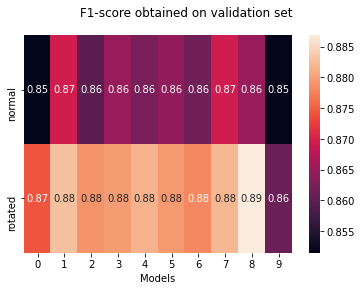

In [ ]:
sns.heatmap(scores_multiple.T ,yticklabels=typing,annot=True)
plt.xlabel("Models")
plt.suptitle("F1-score obtained on validation set")
plt.show()

In [ ]:
#@title Comparing weighted vs unweighted BCE


folder_name = "avg_preds/"
Path(validation_prediction_path + folder_name + "normal/").mkdir(parents=True, exist_ok=True)
Path(validation_prediction_path + folder_name + "rotated/").mkdir(parents=True, exist_ok=True)
average_type = ['fair','f1_weigthed']

scores_multiple = np.empty((len(average_type), len(typing)))

for i,avg_typ in enumerate(average_type) :
  for j,typ in enumerate(typing) :
    predictions =  all_predictions[j:][::2] 
    f1_scores = all_f1_scores[j:][::2] 
    weights = generate_F1_weights(f1_scores)
    if avg_typ == 'fair' :
      avg_predictions = average_prediction(predictions,weights=None)
    else :
      avg_predictions = average_prediction(predictions,weights=weights)


    train_imgs = avg_predictions[:NUM_TRAIN]
    valid_imgs = avg_predictions[NUM_TRAIN:]
    train_target    = new_y[:NUM_TRAIN]
    valid_target    = new_y[NUM_TRAIN:]

    #Find best threshold on test images
    best_func, best_thresh, best_score = select_best_threshold(THRESHOLDS, train_imgs, train_target.astype(int))

    #Use selected threshold on the rest of validation images
    score = compute_score_thresholded(best_func, valid_imgs, valid_target)
    scores_multiple[i,j] = score
    print("Averaged {} in {} mode : {:.3f}, obtained with selected threshold of {:03.0f}".format(typ,avg_typ,score,best_thresh))
 

Averaged normal in fair mode : 0.881, obtained with selected threshold of 114
Averaged rotated in fair mode : 0.883, obtained with selected threshold of 122
Averaged normal in f1_weigthed mode : 0.881, obtained with selected threshold of 114
Averaged rotated in f1_weigthed mode : 0.883, obtained with selected threshold of 122


Text(0.5, 0.98, 'F1-score obtained on validation set')

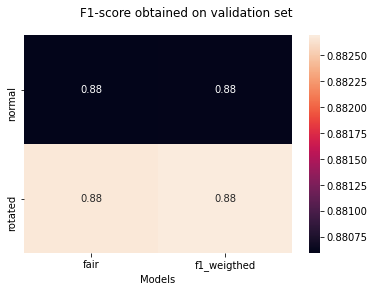

In [ ]:
sns.heatmap(scores_multiple.T ,xticklabels=average_type,yticklabels=typing,annot=True)
plt.xlabel("Models")
plt.suptitle("F1-score obtained on validation set")

We can see that averaging small models can be very powerful. The best solution when averaging them is to do average them fairly i.e all models have the same weight. Averaging with weights computed from the F1 score of each model doesn't show any significant change and can therefor be discarded.

# Selecting Post-Processing techniques

In this section, we keep a fixed model and predictions, and see if we can improve the f1-score simply by appling transforms to the predictions.

In [ ]:
model = keras.models.load_model('models/Level7/model_05_notebook.h5')

## Selecting Stride & Using rotations

We have two methods which can predict an image given a model : predict_from_image and predict_from_image_rotated. The first one simply predicts roads, from multiple window views from an image, given a window size and a stride, and merges the predictions together, so as to predict an entire road. The second does the same thing, but for each window, it rotates it by by [0,90,180,270] degrees, predicts the roads, and un-rotates the prediction, so as to average results from more predictions, in order to capture more potential roads.

In [ ]:
#Define strides we would like to test for
STRIDES   = [48,72,144]
ROTATIONS = [0,90,180,270]
THRESHOLDS = [(x,create_vanilla_threshold(x)) for x in np.linspace(0.1*255,0.7*255,num=20)]
scores = np.empty((2,len(STRIDES)))

#Select best threshold for each prediction type, it is not affected by stride
train_predictions  = [np.asarray(predict_from_image(model, train_x[i], stride=144)) for i in tqdm(range(train_x.shape[0]),desc='Selecting threshold',leave=False)]
train_predictions_rot = [np.asarray(predict_from_image_rotated(model, train_x[i], stride=144, rotations=ROTATIONS, pad=False)) for i in tqdm(range(train_x.shape[0]),desc='Selecting threshold',leave=False)]
best_func, best_thresh, best_score = select_best_threshold(THRESHOLDS, train_predictions, train_y)
best_func_rot, best_thresh_rot, best_score_rot = select_best_threshold(THRESHOLDS, train_predictions_rot, train_y)
print(f'Best thresholds {best_thresh} (no rotation), {best_thresh_rot} (with rotations)')

#Validate best prediction type
for i,s in enumerate(STRIDES):
  #Predictions
  normal_predictions  = [np.asarray(predict_from_image(model, new_x[i], stride=s)) for i in tqdm(range(new_x.shape[0]),desc=f'Stride {s} normal predictions',leave=False)]
  rotated_predictions = [np.asarray(predict_from_image_rotated(model, new_x[i], stride=s, rotations=ROTATIONS, pad=False)) for i in tqdm(range(new_x.shape[0]),desc=f'Stride {s} rotated predictions',leave=False)]
  
  #Compute scores
  normal_score  = compute_score_thresholded(best_func, normal_predictions, new_y)
  rotated_score = compute_score_thresholded(best_func, rotated_predictions, new_y)
  
  scores[0,i] = normal_score
  scores[1,i] = rotated_score 

Best thresholds 122.13157894736841 (no rotation), 97.97368421052632 (with rotations)


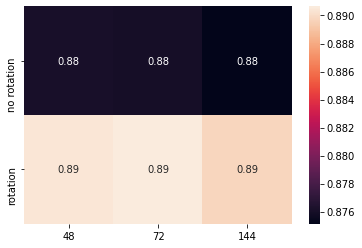

In [ ]:
sns.heatmap(scores, xticklabels=STRIDES, yticklabels=['no rotation','rotation'], annot=True)
plt.show()

We see that rotations of multiple of 90 degrees and averaging allows us to get better results. It doesn't look like there is a significant change with respect to the validation accuracies for different stride values however, although the stride of 72 seems to lead to slightly better accuracy.

In [ ]:
#Perform validation predictions using the previously selected threshold
predictions = [best_func_rot(np.asarray(predict_from_image_rotated(model, new_x[i], stride=72, rotations=ROTATIONS, pad=False)))*255 for i in tqdm(range(new_x.shape[0]),desc=f'Predicting',leave=False)]
stacked = np.stack(predictions)

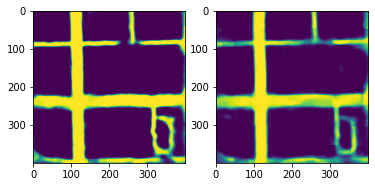

True

In [ ]:
#@title Visual comparison higher stride no rotation versus rotating and superposed

# minimal vs maximal post processing
# create output folder to save for paper
viz_path = "viz_postprocessing/"
Path(viz_path).mkdir(parents=True, exist_ok=True)

# chose train image 26 as it 
example_n = 26
no_rot = predict_from_image(model, train_x[example_n], stride=144)
with_rot = predict_from_image_rotated(model, train_x[example_n], stride=48, 
                                      rotations=ROTATIONS, pad=False)

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(no_rot)
axs[1].imshow(with_rot)
plt.show()

cv2.imwrite(viz_path + 'minimal.png', no_rot)
cv2.imwrite(viz_path + 'maximal.png', with_rot)

In [ ]:
def f1_score_params(post_process_func, params, preds, valid_y):
  scores = []
  for param in tqdm(params, leave=False):
    post_processed = [post_process_func(preds[i].astype('uint8'), **param) for i in range(preds.shape[0])]
    post_processed = np.stack(post_processed)
    scores.append(f1_score(np.ravel(valid_y), np.ravel(best_func_rot(post_processed))))
  return scores

## Gaussian blur
<img src=https://opencv-python-tutroals.readthedocs.io/en/latest/_images/gaussian.jpg height="200">

By applying a gaussian blur, we hope that we will be able to fill holes in roads, for trees for example, where we have predicted roads all around some hole, and so the hole will get the mean value around it, which will fill it.

In [ ]:
# Example function usage: smooth_predictions(pred, steps=5, kernel_size=31)
KERNEL_SIZES = {
    'kernel_size': [1,3,5,11],
    'steps'      : np.arange(5)+1 }

f1_scores = f1_score_params(smooth_predictions, ParameterGrid(KERNEL_SIZES), stacked, new_y)
f1_scores = np.array(f1_scores).reshape((len(KERNEL_SIZES['steps']), len(KERNEL_SIZES['kernel_size'])))

Text(33.0, 0.5, 'Steps')

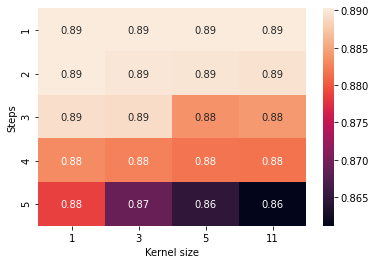

In [ ]:
sns.heatmap(f1_scores, xticklabels=KERNEL_SIZES['kernel_size'], yticklabels=KERNEL_SIZES['steps'],annot=True)
plt.xlabel('Kernel size')
plt.ylabel('Steps')
plt.show()

It looks like the lowest steps lead to the best results, so we conclude that gaussian smoothing is not useful.

## Opening images
![opening](https://opencv-python-tutroals.readthedocs.io/en/latest/_images/opening.png)

The opening morphological operation should allow us to remove small points in our image that are considered as roads, but don't connect to anything.

Text(0.5, 0.98, 'F1-score obtained on validation set')

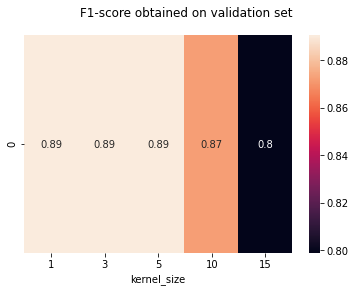

In [ ]:
# Example function usage: open_pred(img, kernel_size=20)

KERNEL_SIZES = {'kernel_size':[1,3,5,10,15]}

f1_scores = f1_score_params(open_pred, ParameterGrid(KERNEL_SIZES), stacked, new_y)
sns.heatmap(np.array(f1_scores).reshape((1,-1)),xticklabels=KERNEL_SIZES['kernel_size'],annot=True)
plt.xlabel('kernel_size')
plt.suptitle("F1-score obtained on validation set")
plt.show()

Since the lowest kernel sizes lead to the best f1 scores, we disregard this postprocessing.

## Closing images
![closing](https://opencv-python-tutroals.readthedocs.io/en/latest/_images/closing.png)

On the other hand, the closing morphological operation should help us fill holes inside roads, where it fills a value as a road, if all pixels around it are considered to be a road (same example as before with the gaussian blur, with a tree on a road).

Text(0.5, 0.98, 'F1-score obtained on validation set')

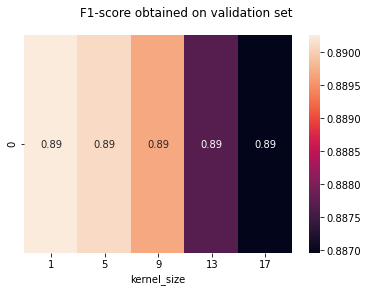

In [ ]:
# Example function usage: close_pred(img, kernel_size=20)

KERNEL_SIZES = {'kernel_size':[1,5,9,13,17]}

f1_scores = f1_score_params(close_pred, ParameterGrid(KERNEL_SIZES), stacked, new_y)
sns.heatmap(np.array(f1_scores).reshape((1,-1)),xticklabels=KERNEL_SIZES['kernel_size'], annot=True)
plt.xlabel("kernel_size")
plt.suptitle("F1-score obtained on validation set")

Since the lowest kernel sizes lead to the best f1 scores, we disregard this postprocessing.

## Hough transform : detecting lines
<img src=https://opencv-python-tutroals.readthedocs.io/en/latest/_images/houghlines5.jpg height="200">

Hough transform can be used to detect lines in an image. Using it, we hope that we are able to match lines which have missing segments : it accepts a max_line_gap parameter, which we can use to fill a continuous line instead of multiple segments of roads.

In [ ]:
# Example function usage: hough_find_lines(pred, rho=1, theta=np.pi/180, threshold=70, min_line_length=50, max_line_gap=50)

params = {
    'min_line_length' : [100,300,500,700],
    'max_line_gap'    : [1,5,10,20,50,100],
    'threshold'       : [10,30,70,100]
    }

def hough_add(pred, **kwargs):
  return pred + hough_find_lines(pred, **kwargs)

f1_scores = np.array(f1_score_params(hough_add, ParameterGrid(params), stacked, new_y))

Text(0.5, 0.98, 'F1-score obtained on validation set')

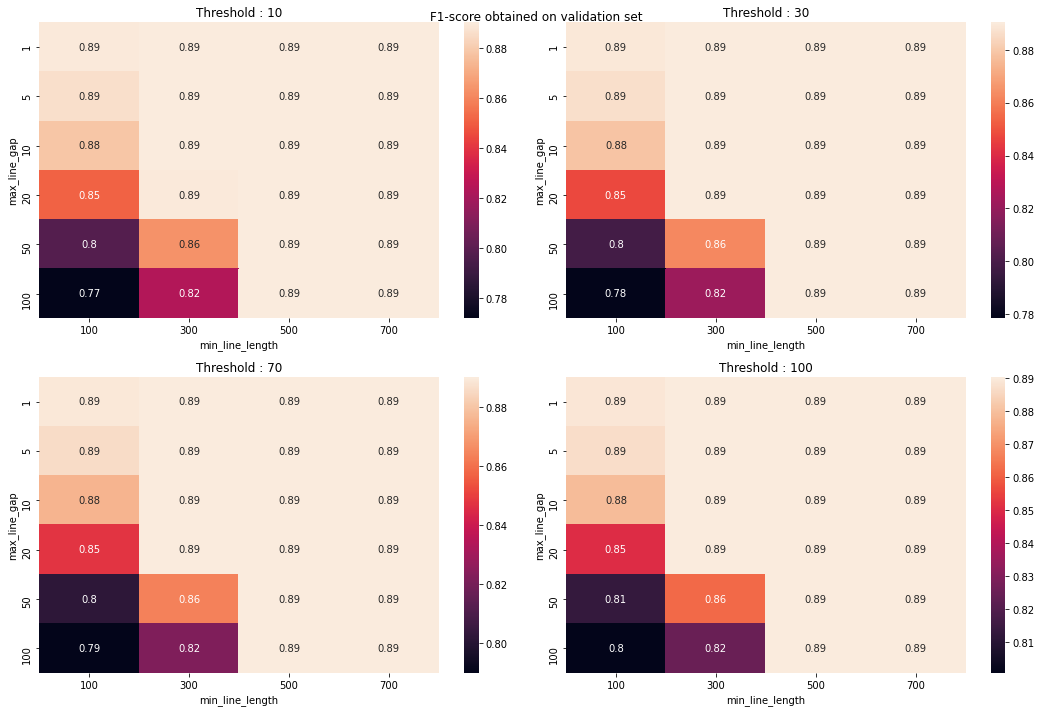

In [ ]:
f1_scores = f1_scores.reshape((len(params['max_line_gap']), len(params['min_line_length']), len(params['threshold'])))
fig, axs = plt.subplots(2,2, figsize=(15,10))
for i,ax in zip(range(f1_scores.shape[2]),axs.flatten()):
  sns.heatmap(f1_scores[:,:,i],xticklabels=params['min_line_length'], yticklabels=params['max_line_gap'], annot=True, ax=ax)
  ax.set_xlabel("min_line_length")
  ax.set_ylabel("max_line_gap")
  ax.set_title(f"Threshold : {params['threshold'][i]}")
plt.tight_layout()

plt.suptitle("F1-score obtained on validation set")

We see that the model performs better when no lines are found, so there is no reason to use hough transform in this case. It could be useful with other parameters, but we couldnt find anything meaningful in this search.

## Removing small blobs using contour detection
<img src=https://i.stack.imgur.com/IHDn6.jpg height="200">

By using contour detection, we are able to determine multiple "blobs" of pixels, and their areas. By keeping only the blobs which have a high area, we remove all patches considered as a road but that are not connected to any other big road.

Text(0.5, 0.98, 'F1-score obtained on validation set')

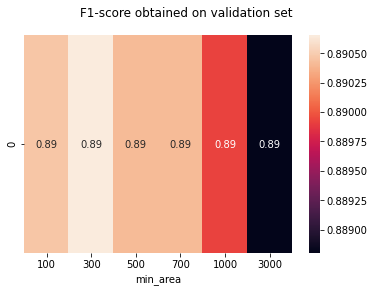

In [ ]:
# Example usage: keep_large_area(img,min_area=2000,max_area=9999999999)

params = {
    'min_area' : [100,300,500,700,1000,3000]
    }

f1_scores = f1_score_params(keep_large_area, ParameterGrid(params), stacked, new_y)
sns.heatmap(np.array(f1_scores).reshape((1,-1)),xticklabels=params['min_area'], annot=True)
plt.xlabel("min_area")

plt.suptitle("F1-score obtained on validation set")

It could look like it is somewhat useful to keep only blobs of size larger than 300, but the results are not very significant (all values are very closely related).

## CNN Integrated Post-Processing

This post-processing is different from the other, as it appends a second model after our current one, and does actually train from data, rather than simply being a grid search like the previous ones.

The idea of the network is taken from http://www.f.waseda.jp/hfs/inpainting_cvpr2017.pdf

And the keras implementation model comes from : https://github.com/hepesu/LineCloser

It adds post processing layers that are meant to join lines together, in order to make sure that every roads are connected

In [ ]:
# Do Not run these cells if you already have another model loaded in GPU : OOM error
post_process_model = keras.models.load_model('./models/level7-postprocessing.h5', compile=False)

In [ ]:
ROTATIONS = [0,90,180,270]
train_predictions_rot = [np.asarray(predict_from_image_rotated(post_process_model, train_x[i], stride=144, rotations=ROTATIONS, pad=False)) for i in tqdm(range(train_x.shape[0]),desc='Selecting threshold',leave=False)]

In [ ]:
THRESHOLDS = [(x,create_vanilla_threshold(x)) for x in np.linspace(0.1*255,0.7*255,num=20)]
best_func_rot, best_thresh_rot, best_score_rot = select_best_threshold(THRESHOLDS, train_predictions_rot, train_y)
print(f'Best threshold : {best_thresh_rot} (with rotations)')

rotated_predictions = [np.asarray(predict_from_image_rotated(post_process_model, new_x[i], stride=144, rotations=ROTATIONS, pad=False)) for i in tqdm(range(new_x.shape[0]),desc=f'Rotated predictions',leave=False)]

In [ ]:
rotated_score = compute_score_thresholded(best_func_rot, rotated_predictions, new_y)
rotated_score

0.9024860850445193

This is a great score ! We choose to utilize this model as it leads to the best ever f1-score. For a detail on how it is trained, and creating the submission, please check-out the run.py file.

# Conclusion of our experiments

## Data augmentation parameters

Result of selecting our parameters : using data augmentation by rotating images leads to better results.

## Levels of our U-Net

The higher the level, the better the performance, but we are limited by memory

## Size of sliding window

The higher the size of sliding window, the more context taken into account, and the better the f1-score.

## Weighted loss

Giving more weights to roads in our binary cross entropy did not lead to a better f1-score.

## Averaging models

Averaging model seems to provide with increased accuracy, and may lead to better results, as an ensemble method : many lower complexity networks can yield better score than a single higher complexity one.

## Best post processing techniques

All grid-searched methods did not seem to enhance our predictions in general, but the post-processing CNN gives slightly better results than our default level 7.

